In [36]:
%load_ext autoreload
%autoreload 2

from spectrum import Spectrum
import matplotlib.pyplot as plt
import numpy as np
from atomic_lines import NA_I_LINES, K_I_LINES, CA_I_LINES
from tabulate import tabulate


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


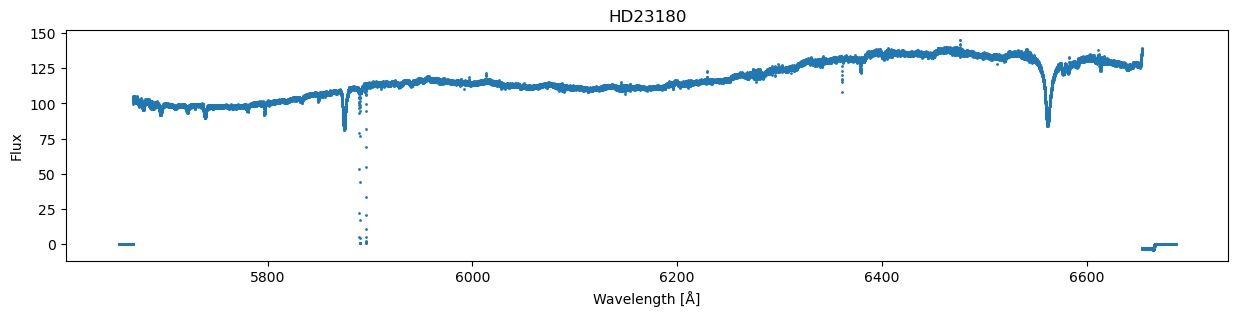

In [37]:
wvl, flux = np.loadtxt('data/DR4/HD23180_w564_n3_20140923_U.ascii', usecols=(0, 3), unpack=True, skiprows=1)

hd23180 = Spectrum('HD23180', wvl, flux)
spectrum_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,3))
hd23180.plot(ax)

Line 1 [Å],Line 2 [Å],Tollerance [Å],Radial velocity [km/s]
5895.7,5889.72,0.006,-11.693


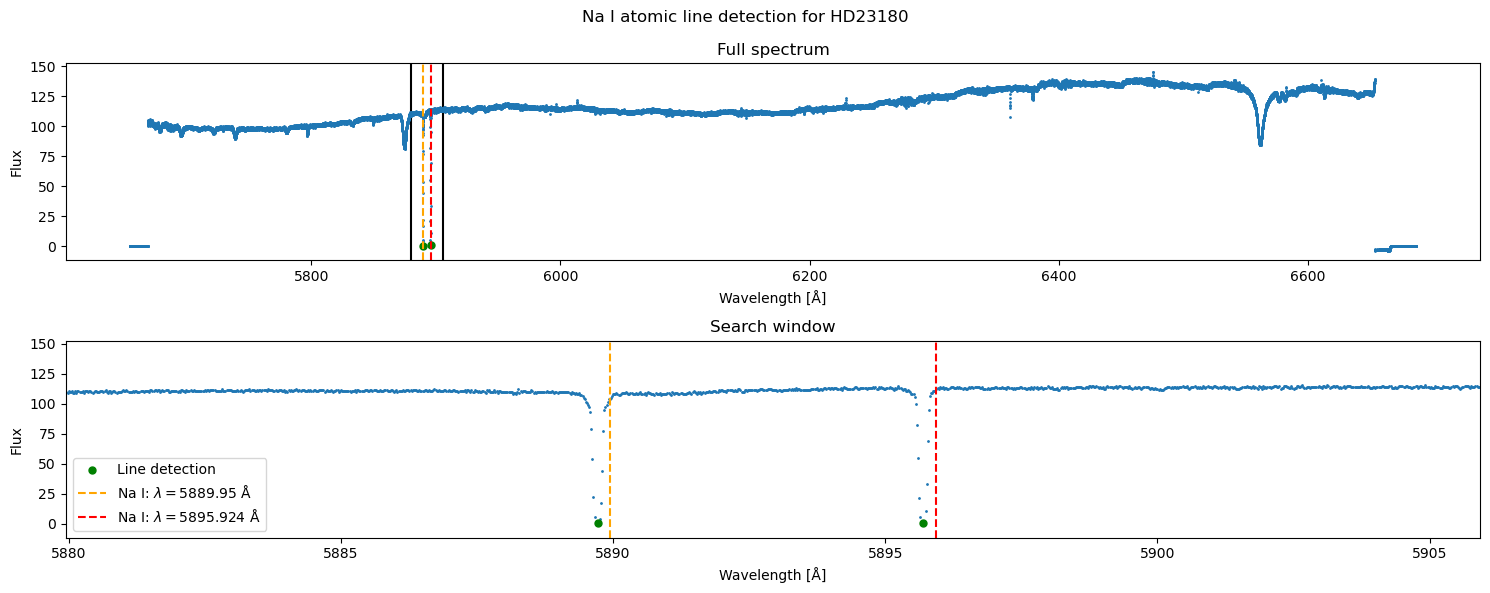

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
na_line_pairs = hd23180.identify_atomic_line(
    NA_I_LINES[0], NA_I_LINES[1],
    axes=axes, draw_expected=True,
    output_tollerance=True,
    output_radial_velocity=True
)

fig.suptitle(f'Na I atomic line detection for {hd23180.target}')
fig.tight_layout()

tabulate(na_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Tollerance [Å]', 'Radial velocity [km/s]'], tablefmt='html')

'<table>\n<thead>\n<tr></tr>\n</thead>\n<tbody>\n</tbody>\n</table>'

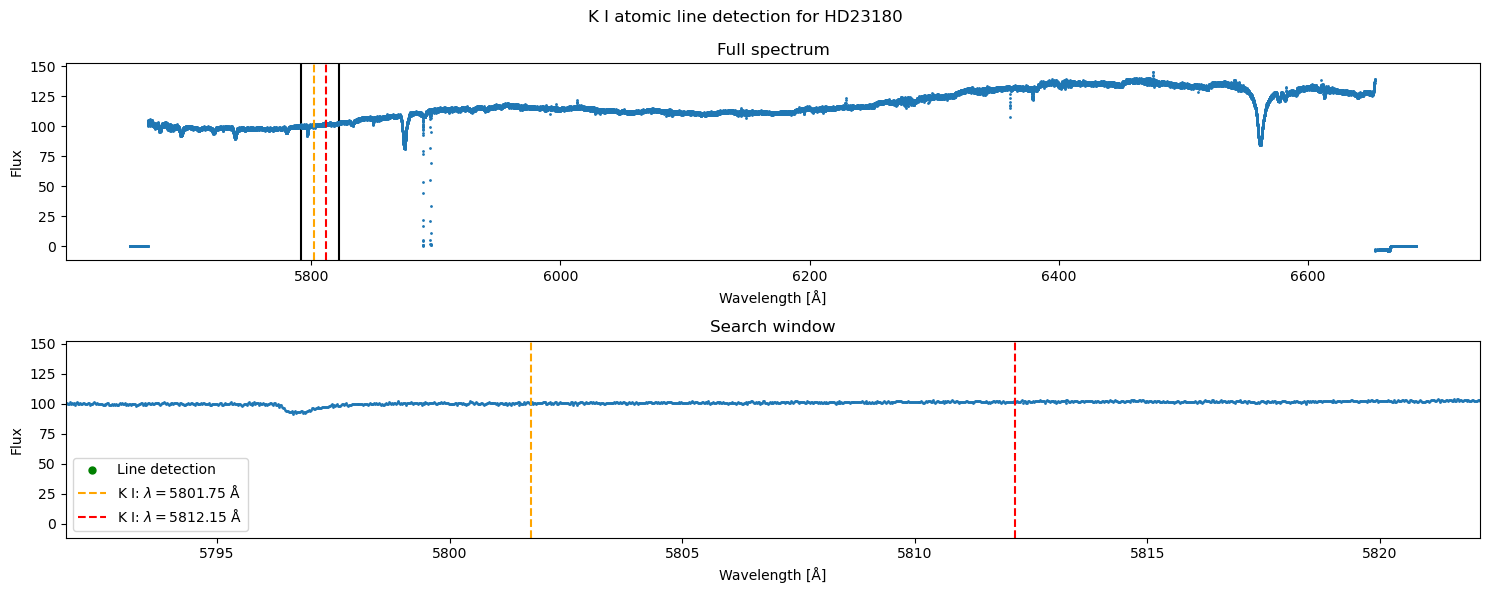

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
k_line_pairs = hd23180.identify_atomic_line(
    K_I_LINES[0], K_I_LINES[1],
    axes=axes, draw_expected=True,
    output_tollerance=True,
    output_radial_velocity=True
)

fig.suptitle(f'K I atomic line detection for {hd23180.target}')
fig.tight_layout()

tabulate(k_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Tollerance [Å]', 'Radial velocity [km/s]'], tablefmt='html')

'<table>\n<thead>\n<tr></tr>\n</thead>\n<tbody>\n</tbody>\n</table>'

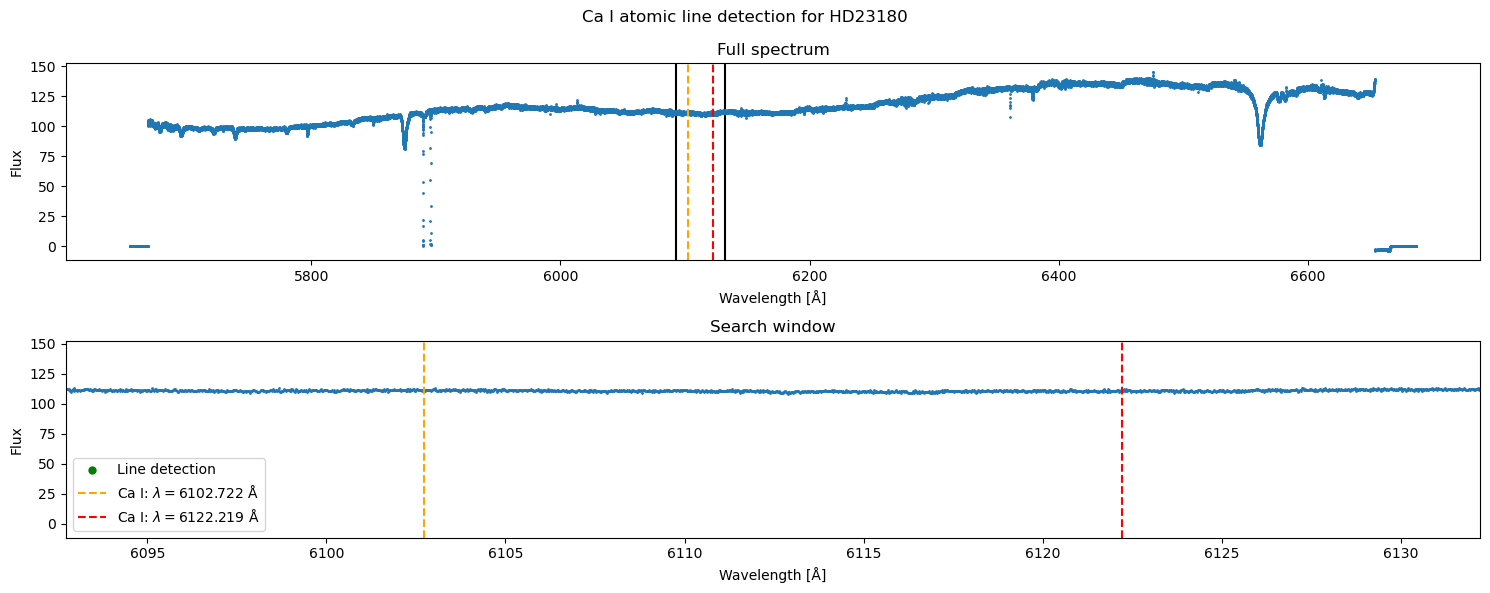

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
ca_line_pairs = hd23180.identify_atomic_line(
    CA_I_LINES[0], CA_I_LINES[1],
    axes=axes, draw_expected=True,
    output_tollerance=True,
    output_radial_velocity=True
)

fig.suptitle(f'Ca I atomic line detection for {hd23180.target}')
fig.tight_layout()

tabulate(ca_line_pairs, ['Line 1 [Å]', 'Line 2 [Å]', 'Tollerance [Å]', 'Radial velocity [km/s]'], tablefmt='html')